<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='imgs/UFF.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

# Machine Learning: Support Vector Machine

### Daniel Junior

# Introdução

Utiliza conceitos de teorias como: Teoria do Aprendizado Estatístico, Teoria das Categorias e Teoria das Restrições.

<b>Teoria do Aprendizado Estatístico</b> estabelece as condições matemáticas para a escolha de um classificador
a partir de um conjunto de treinamento.</br>
Definições necessárias:
* Espaço de entradas
* Espaço de saída
* Considerações (Distribuição Conjunta dos dados de treinamento é uma delas.)
* Função de Perda
* Risco do classificador

Usa um algoritmo <b>Instance Based Learning<b>

Pode ser visto com uma generalização do Perceptron.
No entanto acrescenta recursos cruciais: <b>Kernel, Maximização da Margem e Variáveis de Folga</b>

Possui 3 componentes principais: 

* Support Vectors
* Vetor de pesos
* Kernel

<b>Support Vectors</b> são um subconjunto do conjunto de treinamento que será utilizado como a base de criação da <i>fronteira de decisão</i>. São a partir deles que pode ser calculada a margem máxima entre duas classes, aumentando a <i>confiança</i>.

<b>Vetor de pesos</b> assim como nos métodos vistos anteriormente determina o grau de contribuição das features na classificação, ou ainda, qual lado do hiperplano um novo exemplo estará.

<b>Kernel</b> é uma função que tem como objetivo mapear um dado espaço em outro. Isso é utilizado para casos onde os dados não são linearmente separáveis, então é necessário definir uma transformação onde a representação dos dados neste novo espaço possa ser linearmente separável. Então se utiliza o produto escalar para definir a similaridade.

# SVM: Classificação Binária

## Intuição

* Margem
* Confiança

## SVM Linear

<img src="imgs/svm.jpg" style="margin: 0 auto;"/>

Para o caso de dados com natureza linearmente separável, a fronteira é um hiperplano, como visto na classificação
linear.

O hiperplano que divide os dados pode ser representado por uma equação do tipo:
$$f(x) = w \cdot x + b = 0$$

Podemos utilizar uma função para auxiliar na obtenção das classificações:
$$g(x) = sgn(f(x)) = \left\{
                \begin{array}{ll}
                  +1,\quad \textrm{se}\quad w \cdot x + b > 0\\
                  −1,\quad \textrm{se}\quad w \cdot x + b < 0
                \end{array}
              \right.$$ 
                      


### Problema
<img src="imgs/margin.jpg" style="margin: 0 auto;"/>

Após alguns passos resulta que o problema de maximização da margem 
de separação dos dados em relação ao hiperplano é o problema de otimização:

$$ Minimizar_{w,b} \quad \frac{1}{2} \left| \left| w \right| \right|² \quad \quad \textrm{(1)} $$ 


$$ \textrm{Com as restrições:} \quad y_i(w · x_i + b) − 1 >= 0; \quad ∀i = 1, . . . , n \quad \quad \textrm{(2)} $$


O problema de otimização obtido é quadrático, cuja solução possui uma ampla e estabelecida teoria matemática. Como a função objetivo sendo minimizada é convexa e os pontos que satisfazem as restrições formam um conjunto convexo, esse problema possui um único mínimo global . Problemas desse tipo podem ser solucionados com a introdução de uma função Lagrangiana, que engloba as restrições à função objetivo, associadas a parâmetros denominados multiplicadores de Lagrange $\alpha_i$

Resolvendo a minimização da função Lagrangiana temos o seguinte resultado:
    $$ g(x) = sgn(f(x)) = sgn(\sum\limits_{x_i \in SV} y_i α_i^∗ x_i · x + b^∗) \quad \quad (3)$$ 

### Margens Rígidas vs Margens Suaves

<a href="#" style="clear: left; float: left; margin-bottom: 1em; margin-right: 0.5em;" target="_blank">
<img src="imgs/rigida.png" />
</a><a href="#" style="clear: left; float: left; margin-bottom: 1em; margin-right: 1em;" target="_blank"></a><a href="#" target="_blank"><img src="imgs/suave.png" /></a> 

<b>Margens rígidas: </b>Dado um hiperplano separador, o objetivo é maximizar a distância para os hiperplanos paralelos à ele, entre os quais não existem nenhum dado de treinamento.

<b>Margens suaves:</b> Relaxa a restrição da margem rígida, permitindo algumas (limitadas) violações. Para isso na equação utilizada na maximização da margem são introduzidas <i>variáveis de folga</i> às equações (1) e (2).

Aqui podemos fazer a observação da percepção do SVM ser uma "modernização" do Perceptron. A fronteira de decisão no
caso da classificação binária, é uma equação que retorna -1,1 como resposta de prediçao. No entanto os recursos de kernel, maximização da margem e variáveis de folga o tornam muito mais poderoso. São estes recursos que também o ajudam a evitar o overfitting. 

É possível perceber que temos um problema de otimização de difícil solução analítica.

## Algoritmo SMO

A abordagem clássica (<i>Quadratic Programming Solvers</i>) para resolver o problema de otimização que temos são inviáveis para grande datasets, por questões de tempo e consumo de memória.
<br/><br/>
O <b>SMO</b> reduz esse problema a resolver muitos sub-problemas menores de otimização envolvendo apenas dois multiplicadores de Lagrange por vez. Ou seja, utiliza uma abordagem iterativa.

In [91]:
from __future__ import division, print_function
import os
import numpy as np
import random as rnd

class SVM():
    """
        Simple implementation of a Support Vector Machine using the
        Sequential Minimal Optimization (SMO) algorithm for training.
    """
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
    def fit(self, X, y):
        # Initialization
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(alpha * y, X)
    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        while i == z:
            i = rnd.randint(a,b)
        return i
    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)

In [92]:
import csv

def calc_acc(y, y_hat):
    idx = np.where(y_hat == 1)
    TP = np.sum(y_hat[idx] == y[idx])
    idx = np.where(y_hat == -1)
    TN = np.sum(y_hat[idx] == y[idx])
    return float(TP + TN)/len(y)


def readData(filename, header=True):
    data, header = [], None
    with open(filename, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        if header:
            header = spamreader.next()
        for row in spamreader:
            data.append(row)
    return (np.array(data), np.array(header))

filename = "data/iris-virginica.txt"
(data, _) = readData(filename, header=False)
data = data.astype(float)

positives = np.array([np.array(row) for row in data[:] if row[4] == 1])
negatives = [np.asarray(row) for row in data[:] if row[4] == -1]

training_data = positives[:int(len(positives) * 0.8)]
neg = negatives[:int(len(negatives) * 0.8) ]
training_data = np.concatenate((training_data,neg))

test_data = positives[int(len(positives)* 0.8 ) :]
neg = negatives[int(len(negatives) * 0.8) :]
test_data = np.concatenate((test_data,neg))

X  = training_data[:,0:-1]
y = training_data[:,-1].astype(int)

model = SVM()

# Fit model
support_vectors, iterations = model.fit(X, y)

# Support vector count
sv_count = support_vectors.shape[0]

X_t = test_data[:,0:-1]
y_t = test_data[:,-1].astype(int)

In [93]:
print("Quantidade de vetores de suporte: %d" % (sv_count))
print("Viés:\t\t%.3f" % (model.b))
print("Pesos:\t\t" + str(model.w))
print("Convergência em %d iterações." % (iterations))

y_hat = model.predict(X)
acc = calc_acc(y, y_hat)

print("\n********** Dados de treinamento ************\n")
print("Acurácia:\t%.3f" % (acc))

y_hat = model.predict(X_t)
acc = calc_acc(y_t, y_hat)

print("\n********* Dados de teste *************\n")
print("Acurácia:\t%.3f" % (acc))


Quantidade de vetores de suporte: 63
Viés:		162.757
Pesos:		[ -6.6185702   -2.36149285 -27.92193074 -15.54596774]
Convergência em 11 iterações.

********** Dados de treinamento ************

Acurácia:	0.775

********* Dados de teste *************

Acurácia:	0.433


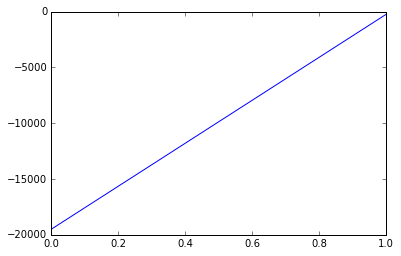

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

first = np.sum(model.w * X[0:])
last = np.sum(model.w * X[-1:])
plt.plot([first, last])

No entanto, a maior parte dos problemas reais não possui todas as características que são necessárias para aplicação da solução acima. Mais especificamente, os dados não podem ser separados por um hiperplano no espaço original das entradas. Então é necessário realizar o mapeamento utilizando alguma função Kernel.

## SVM Não-Linear

<img src="imgs/nonlinear.jpg"/>

## Kernel Trick

Em termos práticos a transformação de um conjunto de entrada de um espaço para outro demanda um esforço computacional muito grande.


A solução é utilizar uma função de similaridade que possa ser calculada em termos do espaço original, mas com seu resultado referindo ao espaço transformado.

Utilizando uma função de kernel $\theta$ apropriada, alteramos a equação (3) e obtemos o seguinte classificador:
    $$ g(x) = sgn(f(x)) = sgn(\sum\limits_{x_i \in SV} y_i α_i^∗ \theta (x_i) · \theta (x) + b^∗) $$